In [1]:
from tpot import TPOTClassifier, TPOTRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, tree, svm
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,roc_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif, SelectKBest

In [2]:
# Import data
df = pd.read_csv('cleaned_data.csv')

# Split the data frame into input and target data frames
X = df.ix[:, df.columns != 'fraud']
y = df.ix[:, df.columns == 'fraud']

# Shuffle and partition our data into 80% train data and 20% test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Use undersampling to create a balanced set
# Number of data points in the minority class
number_records_fraud = len(y_train[y_train['fraud'] == 1])
fraud_indices = np.array(y_train[y_train['fraud'] == 1].index)

# Picking the indices of the normal classes
normal_indices = y_train[y_train['fraud'] == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'fraud']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'fraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data['fraud'] == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data['fraud'] == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  4220


In [3]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, scoring='precision')
tpot.fit(pd.np.array(X_undersample), pd.np.array(y_undersample).ravel())

#Score the accuracy
tpot.score(np.array(X_test), np.array(y_test))

Generation 1 - Current best internal CV score: 0.9930398279866409


Generation 2 - Current best internal CV score: 0.9930398279866409


Generation 3 - Current best internal CV score: 0.9930398279866409


Generation 4 - Current best internal CV score: 0.9930398279866409


Generation 5 - Current best internal CV score: 0.9930398279866409



Best pipeline: BernoulliNB(input_matrix, 0.19, 90.0)


0.82954545454545459

In [4]:
tpot.export('pipeline4.py')

In [5]:
# # High sensitivity, low specificity and accuracy
# clf = make_pipeline(
#     make_union(VotingClassifier([("est", tree.DecisionTreeClassifier())]), FunctionTransformer(lambda X: X)),
#     make_union(VotingClassifier([("est", RandomForestClassifier(n_estimators=500))]), FunctionTransformer(lambda X: X)),
#     VarianceThreshold(threshold=0.92),
#     SelectPercentile(percentile=37, score_func=f_classif),
#     BernoulliNB(alpha=0.53, binarize=0.22, fit_prior=True)
# )

# # Balanced metrics, roc_auc metric
# clf = make_pipeline(
#     make_union(VotingClassifier([("est", MultinomialNB(alpha=23.0, fit_prior=True))]), FunctionTransformer(lambda X: X)),
#     RandomForestClassifier(n_estimators=500)
# )

# # Balanced metrics, default
# clf = make_pipeline(
#     make_union(VotingClassifier([("est", GaussianNB())]), FunctionTransformer(lambda X: X)),
#     RandomForestClassifier(n_estimators=500)
# )

# # Balanced mtrics, f1
# clf = make_pipeline(
#     make_union(VotingClassifier([("est", MultinomialNB(alpha=0.34, fit_prior=True))]), FunctionTransformer(lambda X: X)),
#     make_union(VotingClassifier([("est", RandomForestClassifier(n_estimators=500))]), FunctionTransformer(lambda X: X)),
#     svm.LinearSVC(C=0.58, dual=False, penalty="l1")
# )

# # Very high specificity and low sensitivity, precision
clf = make_pipeline(
    BernoulliNB(alpha=0.19, binarize=90.0, fit_prior=True)
)

# Training the data
clf.fit(X_undersample, y_undersample)

# Scoring the model
accuracy = clf.score(X_test, y_test)

# Printing the score of the model
print(accuracy)

C:\Users\Jonathan\AppData\Local\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9786


In [6]:
# Predicting the test data
y_pred = np.array(clf.predict(X_test))
y_test = np.array(y_test)
y_test.resize(len(y_pred))

# Displaying a confusion matrix
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(df_confusion)

Predicted      0    1
Actual               
0          19426   30
1            398  146


In [7]:
sensitivity = (df_confusion[1][1] / (df_confusion[1][1] + df_confusion[0][1])) * 100
specificity = (df_confusion[0][0] / (df_confusion[1][0] + df_confusion[0][0])) * 100
accuracy *= 100
print('Sensitivity: %s' % sensitivity)
print('Specificity: %s' % specificity)
print('Accuracy: %s' % accuracy)

Sensitivity: 26.8382352941
Specificity: 99.8458059211
Accuracy: 97.86


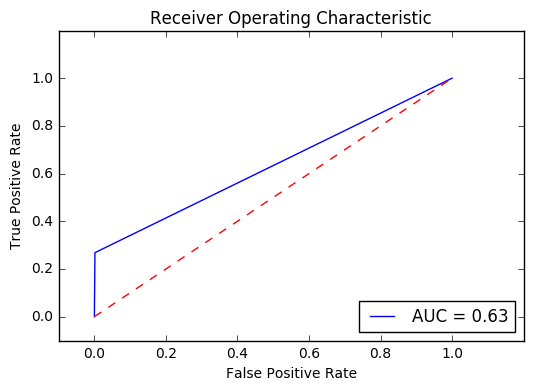

In [8]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()